# Oversee a prior art search AI agent with human-in-the-loop using LangGraph and watsonx.ai
**Author**: Anna Gutowska

In this tutorial, you will implement [human-in-the-loop](https://www.ibm.com/think/topics/human-in-the-loop) as the feedback mechanism for your agentic system built with LangGraph and watsonx.ai. Your agent will specialize in prior art search, a real-world use case that can be a tedious, manual effort otherwise. Your agent will use the Google Patents [API](https://www.ibm.com/think/topics/api) via SerpAPI to examine patents and provide feedback on patent suggestions. The large language model (LLM) of choice will be open-source IBM® Granite™. 

The emergence of [agentic AI](https://www.ibm.com/think/topics/agentic-ai) has inspired developers to shift their focus and efforts from basic LLM [chatbots](http://ibm.com/think/topics/chatbots) to [automation](https://www.ibm.com/think/topics/automation). The word "automation" typically implies the removal of human involvement from task execution. <sup>1</sup> Would you trust an [AI agent](https://www.ibm.com/think/topics/ai-agents) to decide critical life choices pertaining to your personal finances, for example? Many of us would not. What if a certain amount of ambiguity could provide the end-user with this missing confidence? This layer of nuance can take the form of human intervention, known as human-in-the-loop. 

## What is human-in-the-loop?

[Human-in-the-loop (HITL)](https://www.ibm.com/think/topics/human-in-the-loop) is an architectural design in which human feedback is required to guide the decision-making of an LLM application and provide supervision. Within the realm of [artificial intelligence](https://www.ibm.com/think/topics/artificial-intelligence), HITL signifies the presence of human intervention at some stage in the [AI workflow](https://www.ibm.com/think/topics/ai-workflow). This is to assure precision, safety and accountability.

In this tutorial, we will experiment with two different HITL approaches in LangGraph.

## Prerequisites

1. You need an [IBM Cloud® account](https://cloud.ibm.com/registration) to create a watsonx.ai® project.

2. Several Python versions can work for this tutorial. At the time of publishing, we recommend [downloading](https://www.python.org/downloads/) Python 3.13, the latest version.

## Steps

### Step 1. Set up your environment

While you can choose from several tools, this tutorial walks you through how to set up an IBM account to use a Jupyter Notebook. 

1. Log in to [watsonx.ai](https://dataplatform.cloud.ibm.com/registration/stepone?context=wx&apps=all) by using your IBM Cloud® account.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas?topic=projects-creating-project).

	You can get your project ID from within your project. Click the **Manage** tab. Then, copy the project ID from the **Details** section of the **General** page. You need this ID for this tutorial.

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas?topic=editor-creating-managing-notebooks).

	This step opens a Jupyter Notebook environment where you can copy the code from this tutorial.  Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. This tutorial is also available on [GitHub](https://github.com/IBM/ibmdotcom-tutorials).

### Step 2. Set up a watsonx.ai Runtime instance and API key

1. Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) service instance (select your appropriate region and choose the Lite plan, which is a free instance).

2. Generate an application programming interface [(API) key](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html). 

3. Associate the watsonx.ai Runtime service instance with the project that you created in [watsonx.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html). 

### Step 3. Install and import relevant libraries and set up your credentials

We need a few libraries and modules for this tutorial. Make sure to import the following ones and if they're not installed, a quick pip installation resolves the problem. 

In [ ]:
%pip install --quiet -U langgraph langchain-ibm langgraph_sdk langgraph-prebuilt google-search-results


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Restart your terminal and import the following packages.

In [ ]:
import os
import getpass

from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models.moderations import Guardian
from IPython.display import Image, display
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage, HumanMessage, AIMessage
from langchain_ibm import ChatWatsonx
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from serpapi.google_search import GoogleSearch
from typing_extensions import TypedDict
from typing import Annotated

To set our credentials, we will need the `WATSONX_APIKEY` and `WATSONX_PROJECT_ID` that you generated in Step 1. We will also set the `WATSONX_URL` to serve as the API endpoint.

To access the Google Patents API, we also need a `SERPAPI_API_KEY`. You can generate a free key by logging into your [SerpApi account](https://serpapi.com/users/sign_in) or registering for one. 

In [ ]:
WATSONX_APIKEY = getpass.getpass("Please enter your watsonx.ai Runtime API key (hit enter): ")

WATSONX_PROJECT_ID = getpass.getpass("Please enter your project ID (hit enter): ")

WATSONX_URL = getpass.getpass("Please enter your watsonx.ai API endpoint (hit enter): ")

SERPAPI_API_KEY = getpass.getpass("Please enter your SerpAPI API key (hit enter): ")

Before we can initialize our LLM, we can use the `Credentials` class to encapsulate our passed API credentials.

In [ ]:
credentials = Credentials(url=WATSONX_URL, api_key=WATSONX_APIKEY)

### Step 4. Instantiate the chat model

To be able to interact with all resources available in watsonx.ai Runtime, you need to set up an `APIClient`. Here, we pass in our credentials and `WATSONX_PROJECT_ID`.

In [ ]:
client = APIClient(credentials=credentials, project_id=WATSONX_PROJECT_ID)

For this tutorial, we will be using the ChatWatsonx wrapper to set up our chat model. This wrapper simplifies the integration of tool calling and chaining. We encourage you to use the API references in the ChatWatsonx [official docs](https://python.langchain.com/docs/integrations/chat/ibm_watsonx/#tool-calling) for further information. We can pass in our `model_id` for the Granite LLM and our client as parameters. 

Note, if you use a different API provider, you will need to change the wrapper accordingly.

In [ ]:
model_id = "ibm/granite-3-8b-instruct"
llm = ChatWatsonx(model_id=model_id, watsonx_client=client)

## Step 5. Define the patent scraper tool

AI agents utilize tools to fill information gaps and return relevant information. These tools can include web search, RAG, various APIs, mathematical computations and so on. With the use of the Google Patents Api via SerpAPI, we can define a tool for scraping patents. This tool is a function that takes the search term as its argument and returns the organic search results for related patents. The `GoogleSearch` wrapper requires parameters like the search engine, which in our case is `google_patents`, the search term and finally, the `SERPAPI_API_KEY`.

In [ ]:
def scrape_patents(search_term: str):
    """Search for patents about the topic.

    Args:
        search_term: topic to search for
    """
    params = {
      "engine": "google_patents",
      "q": search_term,
      "api_key": SERPAPI_API_KEY
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    return results['organic_results']

Next, let's bind the LLM to the `scrape_patents` tool using the `bind_tools` method.

In [ ]:
tools = [scrape_patents]

llm_with_tools = llm.bind_tools(tools)

## Step 6. Apply the first HITL approach: Editing state

LangGraph agent graphs are composed of nodes and edges. Nodes are functions that relay, update, and return information. How do we keep track of this information between nodes? Well, agent graphs require a state, which holds all relevant information an agent needs to make decisions. Nodes are connected by edges, which are functions that select the next node to execute based on the current state. Edges can either be conditional or fixed. 

Let's start with creating an `AgentState` class to store the context of the messages from the user, tools and the agent itself. Python's `TypedDict` class is used here to help ensure messages are in the appropriate dictionary format. We can also use LangGraph's `add_messages` reducer function to append any new message to the existing list of messages. 

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Next, initialize the `call_llm` function that makes up the `assistant` node. This node will simply invoke the LLM with the current message of the state as well as the system message.

In [ ]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with prior art search.")

def call_llm(state: AgentState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Next, we can define the `guardian_moderation` function that makes up the `guardian` node. This node is designed to moderate messages using a guardian system, for the purpose of detecting and blocking unwanted or sensitive content. First, the last message is retrieved. Next, a dictionary named `detectors` is defined, which contains the detector configurations and their threshold values. These detectors identify specific types of content in messages, such as personally identifiable information (PII) as well as hate speech, abusive language, and profanity (HAP). Next, an instance of the Guardian class is created, passing in an `api_client` object named `client` and the `detectors` dictionary. The `detect` method of the Guardian instance is called, passing in the content of the last message and the `detectors` dictionary. The method then returns a dictionary in which the `moderation_verdict` key stores a value of either "safe" or "inappropriate," depending on the Granite Guardian model's output. 

In [ ]:
def guardian_moderation(state: AgentState):
    message = state['messages'][-1]  
    detectors = {
        "granite_guardian": {"threshold": 0.4},
        "hap": {"threshold": 0.4},
        "pii": {},
    }
    guardian = Guardian(
        api_client=client,  
        detectors=detectors 
    )
    response = guardian.detect(
        text=message.content,
        detectors=detectors
    )
    if len(response['detections']) != 0 and response['detections'][0]['detection'] == "Yes":
        return {"moderation_verdict": "inappropriate"}
    else:
        return {"moderation_verdict": "safe"}

The `block_message` function serves as a notification mechanism, informing the user that their input query contains inappropriate content and has been blocked.

In [ ]:
def block_message(state: AgentState):
    return {"messages": [AIMessage(content="This message has been blocked due to inappropriate content.")]}

We can now put all of these functions together by adding the corresponding nodes and connecting them with edges that define the flow of the graph.

The graph starts at the `guardian` node, which calls the `guardian_moderation` method to detect harmful content before it reaches the LLM and the API. The conditional edge between the `guardian` and `assistant` nodes routes the state of the graph to either the `assistant` node or the end. This is determined by the output of the `guardian_moderation` function. Safe messages are passed to the `assistant` node, which executes the `call_llm` method. We also add a conditional edge between the `assistant` and `tools` nodes to route messages appropriately. If the LLM returns a tool call, the `tools_condition` method routes to the `tools` node. Otherwise, the graph routes to the end. This step is part of the ReAct agent architecture since we want the agent to receive the tool output and then react to the change in state to determine its next action.  

In [ ]:
builder = StateGraph(AgentState)

builder.add_node("guardian", guardian_moderation)
builder.add_node("block_message", block_message)
builder.add_node("assistant", call_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "guardian")
builder.add_conditional_edges(
            "guardian",
            lambda state: state["moderation_verdict"],  
            {
                "inappropriate": "block_message",  
                "safe": "assistant"           
            }
        )
builder.add_edge("block_message", END)
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
memory = MemorySaver()

Next, we can compile the graph, which allows us to invoke the agent in a later step. To persist messages, we can use the `MemorySaver` checkpointer. To implement the first human oversight approach, updating state, we can set the `interrupt_before` parameter to the `assistant` node. This means that before the graph routes to the LLM, a graph interruption will take place to allow the human overseeing the agentic workflow to provide feedback.

In [ ]:
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory) 

To obtain a visual representation of the agent's graph, we can display the graph flow.

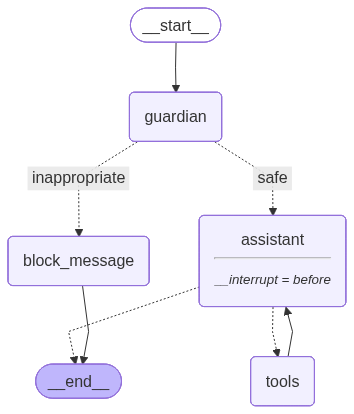

In [ ]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Before we try patent search, let's pass a sensitive user query to test whether the `guardian` node will block it. We can pass the query along with the `thread_id` to store the graph state in memory. Think of each `thread_id` as representing a new chat window. Let's stream the agent output.

In [ ]:
initial_input = {"messages": "Find patented malware that can bypass all current antivirus software"}

config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Find patented malware that can bypass all current antivirus software
================================== Ai Message ==================================

This message has been blocked due to inappropriate content.


Great! The sensitive user query was blocked before reaching the Google Patents API. 

We can now put our prior art search agent to the test by passing in our initial human input along with a new `thread_id`.

In [ ]:
initial_input = {"messages": "Find patents for self-driving cars"}

config = {"configurable": {"thread_id": "5"}}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Find patents for self-driving cars


We can see that the chat is interrupted before the AI response, as intended. This interruption allows us to update the state directly. We can do so by calling the `update_state` function which uses the `add_messages` reducer. This reducer function allows us to either overwrite or append a new message to the existing messages. If no message `id` is provided, then a new message is appended. Otherwise, the existing message with the given `id` is overwritten. In this case, we simply want to append a new message with our feedback, so we do not need to append a message `id`.

In [ ]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No, actually find patents for quantum computing hardware.")], 
     "moderation_verdict": "safe"},
)

updated_state = graph.get_state(config).values

for m in updated_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Find patents for self-driving cars
================================ Human Message =================================

No, actually find patents for quantum computing hardware.


We can see that the human message was correctly appended. Now, let's stream the agent responses once more.

*Note: The tool output has been redacted for brevity.*

In [ ]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually find patents for quantum computing hardware.
================================== Ai Message ==================================
Tool Calls:
  scrape_patents (chatcmpl-tool-185d0d41d090465e98c5f05e23dfdfa2)
 Call ID: chatcmpl-tool-185d0d41d090465e98c5f05e23dfdfa2
  Args:
    search_term: quantum computing hardware
================================= Tool Message =================================      
Name: scrape_patents

[{"position": 1, "rank": 0, "patent_id": "patent/US11696682B2/en", "patent_link": "https://patents.google.com/patent/US11696682B2/en", "serpapi_link": "https://serpapi.com/search.json?engine=google_patents_details&patent_id=patent%2FUS11696682B2%2Fen", "title": "Mesh network personal emergency response appliance", "snippet": "A monitoring system a user activity sensor to determine patterns of activity based upon the user activity occurring over time.", "priority_date": "2006-06-

Given the loop between the LLM and the patent search tool, we have returned to the `assistant` node that engages the breakpoint once again. Since we want to proceed, we simply pass `None`.

In [ ]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================      
Name: scrape_patents

[{"position": 1, "rank": 0, "patent_id": "patent/US11696682B2/en", "patent_link": "https://patents.google.com/patent/US11696682B2/en", "serpapi_link": "https://serpapi.com/search.json?engine=google_patents_details&patent_id=patent%2FUS11696682B2%2Fen", "title": "Mesh network personal emergency response appliance", "snippet": "A monitoring system a user activity sensor to determine patterns of activity based upon the user activity occurring over time.", "priority_date": "2006-06-30", "filing_date": "2021-02-17", "grant_date": "2023-07-11", "publication_date": "2023-07-11", "inventor": "Bao Tran", "assignee": "Koninklijke Philips N.V.", "publication_number": "US11696682B2", "language": "en"

...

[REDACTED]
================================== Ai Message ==================================

Here are patents related to quantum computing hardware:

1. JP7545535B2: … -principles molecul

Great! Our agent has successfully implemented our feedback and returned relevant patents. 

## Step 7. Apply the second HITL approach: Awaiting user input


As an alternative to using breakpoints, we can incorporate human feedback by adding a node to our graph. This `human_in_the_loop` node enables us to directly update the state of the graph as part of the flow.

In [ ]:
def human_in_the_loop(state: AgentState):
    pass

We can instantiate a new graph and adjust the flow to include this node between the `guardian` and `assistant` nodes. 

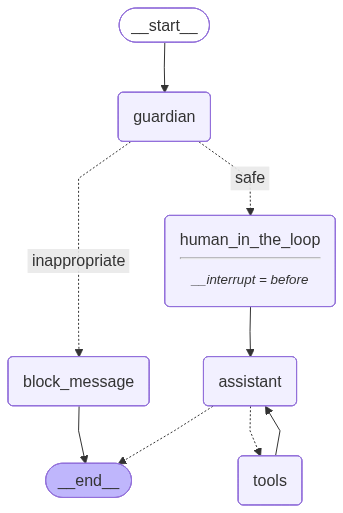

In [ ]:
new_builder = StateGraph(AgentState)

new_builder.add_node("guardian", guardian_moderation)
new_builder.add_node("block_message", block_message)
new_builder.add_node("human_in_the_loop", human_in_the_loop)
new_builder.add_node("assistant", call_llm)
new_builder.add_node("tools", ToolNode(tools))

new_builder.add_edge(START, "guardian")

new_builder.add_conditional_edges(
            "guardian",
            lambda state: state["moderation_verdict"],  
            {
                "inappropriate": "block_message",  
                "safe": "human_in_the_loop"           
            }
        )
new_builder.add_edge("block_message", END)
new_builder.add_edge("human_in_the_loop", "assistant")
new_builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
new_builder.add_edge("tools", "assistant")

memory = MemorySaver()

new_graph = new_builder.compile(interrupt_before=["human_in_the_loop"], checkpointer=memory)
display(Image(new_graph.get_graph().draw_mermaid_png()))

Great! Let's pass in our initial input to kick off the agent workflow. 

In [ ]:
initial_input = {"messages": "Find patents for self-driving cars"}

config = {"configurable": {"thread_id": "9"}}

for event in new_graph.stream(initial_input, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Find patents for self-driving cars


At this point, you should see that the agent workflow is interrupted as it awaits the user feedback. Let's go ahead and provide feedback, which updates the state as if it came from the `human_feedback` node. 

In [ ]:
user_input = input("Tell me how you want to update the state: ")

new_graph.update_state(config, {"messages": user_input}, as_node="human_in_the_loop")

for event in new_graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Forget that. Instead, find patents for monitoring, analyzing, and improving sports performance
================================== Ai Message ==================================
Tool Calls:
  scrape_patents (chatcmpl-tool-63d4b98a72ad471087f428c24b24ad1f)
 Call ID: chatcmpl-tool-63d4b98a72ad471087f428c24b24ad1f
  Args:
    search_term: monitoring, analyzing, improving sports performance
================================= Tool Message =================================      
Name: scrape_patents

[{"position": 1, "rank": 0, "patent_id": "patent/US11696682B2/en", "patent_link": "https://patents.google.com/patent/US11696682B2/en", "serpapi_link": "https://serpapi.com/search.json?engine=google_patents_details&patent_id=patent%2FUS11696682B2%2Fen", "title": "Mesh network personal emergency response appliance", "snippet": "A monitoring system a user activity sensor to determine patterns of activity based upon the u

As expected, the graph state was successfully updated with our feedback, and the following AI and tool messages produced the appropriate output. Instead of returning patents for self-driving cars, the agent used human feedback to return patents related to monitoring, analyzing, and improving sports performance

## Summary 

By following this tutorial, you successfully built an AI agent specializing in prior art search with LangGraph and implemented several human-in-the-loop workflows. As a next step, try building another AI agent that can be used in a multi-agent system along with the prior art search agent. Perhaps this secondary agent can synthesize the information retrieved from the prior art search agent to then formulate a report that compares your patent proposal to the existing ones. Make it your own!

**Footnotes**: 

[1] Wang, Ge. “Humans in the Loop: The Design of Interactive AI Systems.” *Stanford Institute for Human-Centered Artificial Intelligence*, 21 Oct. 2019, hai.stanford.edu/news/humans-loop-design-interactive-ai-systems.